# Regularização

Este notebook apresenta as principais técnicas de regularização utilizadas em deep learning para combater o overfitting e melhorar a generalização dos modelos. Abordaremos a implementação prática usando PyTorch.

## Conteúdos Abordados

1. **Introdução ao Overfitting**: Compreendendo o problema
2. **Dropout**: Regularização através de desativação aleatória
3. **Penalidades de Peso (L1 e L2)**: Weight decay e sparsidade
4. **Early Stopping**: Parada antecipada baseada na validação
5. **Data Augmentation**: Aumentando a diversidade dos dados
6. **Comparação das Técnicas**: Análise experimental

## Setup e Preparação dos Dados

Começamos importando as bibliotecas necessárias e preparando um dataset reduzido do MNIST para experimentos rápidos.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import copy

# Configurações
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Seed para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)

Usando dispositivo: cpu


In [2]:
# Preparação do dataset MNIST reduzido
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset completo
full_train_dataset = torchvision.datasets.MNIST(
    root='./data', train=True, transform=transform, download=True
)
full_test_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, transform=transform, download=True
)

# Criando subsets reduzidos para experimentos rápidos
train_indices = torch.randperm(len(full_train_dataset))[:4000]
val_indices = torch.randperm(len(full_test_dataset))[:1000]

train_dataset = Subset(full_train_dataset, train_indices)
val_dataset = Subset(full_test_dataset, val_indices)

print(f"Dataset de treino: {len(train_dataset)} amostras")
print(f"Dataset de validação: {len(val_dataset)} amostras")

# DataLoaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Dataset de treino: 4000 amostras
Dataset de validação: 1000 amostras


## 1. Introdução ao Overfitting

O **overfitting** ocorre quando um modelo aprende muito bem os dados de treinamento, incluindo o ruído e padrões específicos desses dados, mas falha em generalizar para dados novos. Matematicamente, isso acontece quando a complexidade do modelo é muito alta em relação à quantidade de dados disponíveis.

O **bias-variance tradeoff** é fundamental para entender este fenômeno:

$$\text{Erro Total} = \text{Bias}^2 + \text{Variance} + \text{Ruído Irredutível}$$

- **Bias**: erro devido a suposições simplificadoras no algoritmo
- **Variance**: erro devido à sensibilidade a pequenas flutuações nos dados de treino
- **Ruído Irredutível**: erro inerente ao problema

In [3]:
# Modelo base simples para demonstrar overfitting
class BaseModel(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(BaseModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(784, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    """Função geral de treinamento"""
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validação
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular métricas da época
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = 100 * train_correct / train_total
        epoch_val_acc = 100 * val_correct / val_total

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Época [{epoch+1}/{num_epochs}] - '
                  f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% - '
                  f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [5]:
def evaluate_model(model, data_loader):
    """Função de avaliação do modelo"""
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(data_loader)

    return accuracy, avg_loss

### Experimento Baseline: Modelo sem Regularização

Primeiro, vamos treinar um modelo sem nenhuma técnica de regularização para estabelecer uma baseline e observar o comportamento do overfitting.

Treinando modelo baseline (sem regularização)...
Época [5/30] - Train Loss: 0.1270, Train Acc: 95.92% - Val Loss: 0.2268, Val Acc: 93.20%
Época [10/30] - Train Loss: 0.0167, Train Acc: 99.75% - Val Loss: 0.2320, Val Acc: 93.80%
Época [15/30] - Train Loss: 0.0021, Train Acc: 100.00% - Val Loss: 0.2336, Val Acc: 94.10%
Época [20/30] - Train Loss: 0.0011, Train Acc: 100.00% - Val Loss: 0.2473, Val Acc: 93.70%
Época [25/30] - Train Loss: 0.0007, Train Acc: 100.00% - Val Loss: 0.2562, Val Acc: 93.70%
Época [30/30] - Train Loss: 0.0005, Train Acc: 100.00% - Val Loss: 0.2608, Val Acc: 93.70%


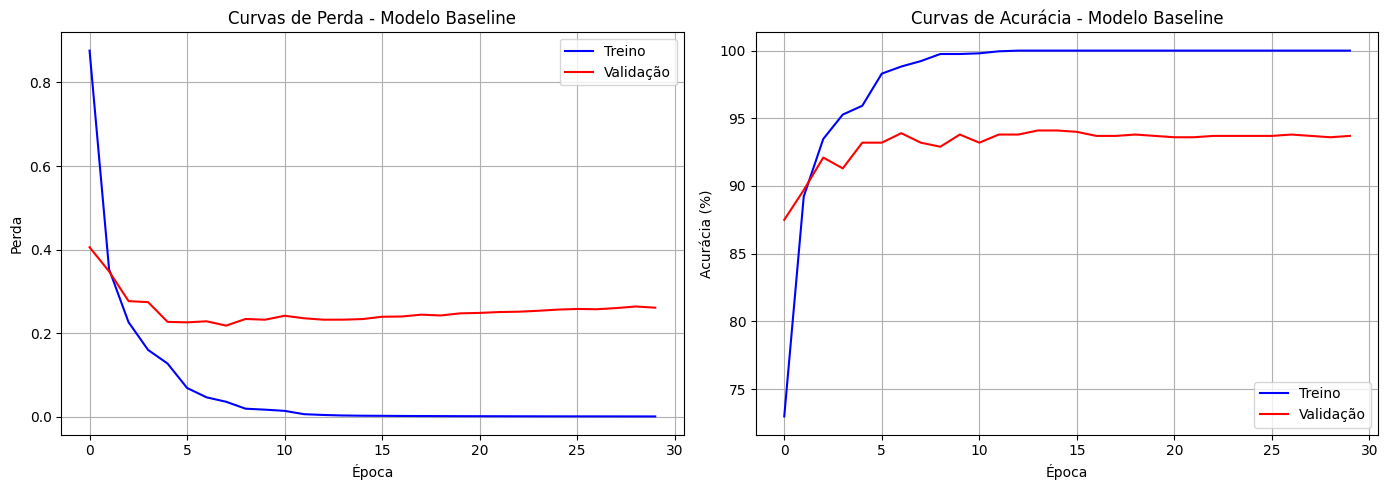


Desempenho final do modelo baseline:
Acurácia de validação: 93.70%
Perda de validação: 0.2608


In [6]:
# Modelo baseline sem regularização
baseline_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(baseline_model.parameters(), lr=0.001)

print("Treinando modelo baseline (sem regularização)...")
baseline_train_losses, baseline_val_losses, baseline_train_acc, baseline_val_acc = train_model(
    baseline_model, train_loader, val_loader, criterion, optimizer, num_epochs=30
)

# Plotar curvas de aprendizado
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Perda
ax1.plot(baseline_train_losses, label='Treino', color='blue')
ax1.plot(baseline_val_losses, label='Validação', color='red')
ax1.set_title('Curvas de Perda - Modelo Baseline')
ax1.set_xlabel('Época')
ax1.set_ylabel('Perda')
ax1.legend()
ax1.grid(True)

# Acurácia
ax2.plot(baseline_train_acc, label='Treino', color='blue')
ax2.plot(baseline_val_acc, label='Validação', color='red')
ax2.set_title('Curvas de Acurácia - Modelo Baseline')
ax2.set_xlabel('Época')
ax2.set_ylabel('Acurácia (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

baseline_val_acc_final, baseline_val_loss_final = evaluate_model(baseline_model, val_loader)
print(f"\nDesempenho final do modelo baseline:")
print(f"Acurácia de validação: {baseline_val_acc_final:.2f}%")
print(f"Perda de validação: {baseline_val_loss_final:.4f}")

## 2. Dropout

O **Dropout** é uma técnica de regularização que, durante o treinamento, desativa aleatoriamente uma fração dos neurônios em cada forward pass. Isso força o modelo a não depender excessivamente de neurônios específicos, melhorando a generalização.

Durante o treinamento, para uma camada com entrada $\mathbf{x}$:

$$\tilde{\mathbf{x}} = \mathbf{r} \odot \mathbf{x}$$

onde:
- $\mathbf{r} \sim \text{Bernoulli}(p)$ é um vetor de máscara aleatória
- $p$ é a probabilidade de manter um neurônio ativo
- $\odot$ denota produto elemento a elemento (Hadamard)

Durante a inferência, todos os neurônios são mantidos ativos, mas suas saídas são escalonadas por $p$ para compensar:

$$\mathbf{x}_{\text{test}} = p \cdot \mathbf{x}$$

In [7]:
# Modelo com dropout
dropout_model = BaseModel(dropout_rate=0.3).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(dropout_model.parameters(), lr=0.001)

print("Treinando modelo com Dropout (rate=0.3)...")
dropout_train_losses, dropout_val_losses, dropout_train_acc, dropout_val_acc = train_model(
    dropout_model, train_loader, val_loader, criterion, optimizer, num_epochs=30
)

Treinando modelo com Dropout (rate=0.3)...
Época [5/30] - Train Loss: 0.1705, Train Acc: 95.15% - Val Loss: 0.2153, Val Acc: 93.30%
Época [10/30] - Train Loss: 0.0713, Train Acc: 97.60% - Val Loss: 0.2199, Val Acc: 93.80%
Época [15/30] - Train Loss: 0.0290, Train Acc: 99.15% - Val Loss: 0.2171, Val Acc: 93.60%
Época [20/30] - Train Loss: 0.0170, Train Acc: 99.55% - Val Loss: 0.2221, Val Acc: 94.30%
Época [25/30] - Train Loss: 0.0185, Train Acc: 99.45% - Val Loss: 0.2200, Val Acc: 94.60%
Época [30/30] - Train Loss: 0.0138, Train Acc: 99.60% - Val Loss: 0.2472, Val Acc: 94.70%


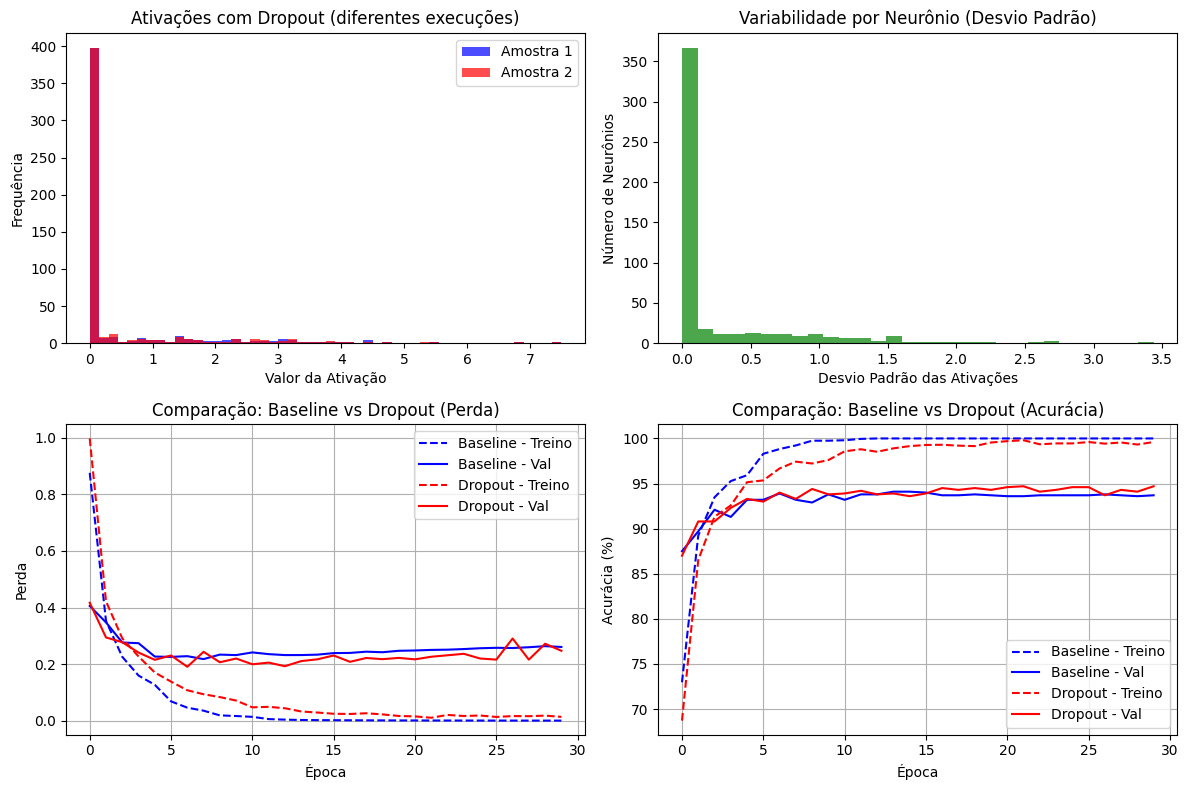


Desempenho do modelo com Dropout:
Acurácia de validação: 94.70%
Perda de validação: 0.2472


In [8]:
# Visualização do efeito do dropout
def visualize_dropout_effect(model, input_tensor, num_samples=10):
    """Visualiza como o dropout afeta as ativações"""
    model.train()  # Ativar dropout

    activations = []
    for _ in range(num_samples):
        with torch.no_grad():
            x = model.flatten(input_tensor)
            x = F.relu(model.fc1(x))
            x = model.dropout1(x)  # Aplicar dropout
            activations.append(x.cpu().numpy())

    return np.array(activations)

# Pegar uma amostra do dataset
sample_data, _ = next(iter(val_loader))
sample = sample_data[0:1].to(device)  # Primeira amostra

# Comparar ativações com e sem dropout
dropout_activations = visualize_dropout_effect(dropout_model, sample)

# Plotar distribuição das ativações
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Ativações com dropout (múltiplas amostras)
axes[0, 0].hist(dropout_activations[0].flatten(), bins=50, alpha=0.7, color='blue', label='Amostra 1')
axes[0, 0].hist(dropout_activations[1].flatten(), bins=50, alpha=0.7, color='red', label='Amostra 2')
axes[0, 0].set_title('Ativações com Dropout (diferentes execuções)')
axes[0, 0].set_xlabel('Valor da Ativação')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].legend()

# Comparação da variabilidade
std_per_neuron = np.std(dropout_activations, axis=0).flatten()
axes[0, 1].hist(std_per_neuron, bins=30, color='green', alpha=0.7)
axes[0, 1].set_title('Variabilidade por Neurônio (Desvio Padrão)')
axes[0, 1].set_xlabel('Desvio Padrão das Ativações')
axes[0, 1].set_ylabel('Número de Neurônios')

# Comparação das curvas de aprendizado
axes[1, 0].plot(baseline_train_losses, label='Baseline - Treino', color='blue', linestyle='--')
axes[1, 0].plot(baseline_val_losses, label='Baseline - Val', color='blue', linestyle='-')
axes[1, 0].plot(dropout_train_losses, label='Dropout - Treino', color='red', linestyle='--')
axes[1, 0].plot(dropout_val_losses, label='Dropout - Val', color='red', linestyle='-')
axes[1, 0].set_title('Comparação: Baseline vs Dropout (Perda)')
axes[1, 0].set_xlabel('Época')
axes[1, 0].set_ylabel('Perda')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(baseline_train_acc, label='Baseline - Treino', color='blue', linestyle='--')
axes[1, 1].plot(baseline_val_acc, label='Baseline - Val', color='blue', linestyle='-')
axes[1, 1].plot(dropout_train_acc, label='Dropout - Treino', color='red', linestyle='--')
axes[1, 1].plot(dropout_val_acc, label='Dropout - Val', color='red', linestyle='-')
axes[1, 1].set_title('Comparação: Baseline vs Dropout (Acurácia)')
axes[1, 1].set_xlabel('Época')
axes[1, 1].set_ylabel('Acurácia (%)')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

dropout_val_acc_final, dropout_val_loss_final = evaluate_model(dropout_model, val_loader)
print(f"\nDesempenho do modelo com Dropout:")
print(f"Acurácia de validação: {dropout_val_acc_final:.2f}%")
print(f"Perda de validação: {dropout_val_loss_final:.4f}")

## 3. Penalidades de Peso (L1 e L2)

As **penalidades de peso** adicionam um termo de regularização à função de custo original, penalizando pesos com magnitudes grandes. Isso encoraja o modelo a aprender representações mais simples.

### Regularização L2 (Weight Decay)

A regularização L2 adiciona o quadrado da magnitude dos pesos à função de custo:

$$\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{original}} + \lambda \sum_{i} w_i^2$$

onde $\lambda$ é o coeficiente de regularização. O gradiente do termo de regularização é:

$$\frac{\partial}{\partial w_i}(\lambda w_i^2) = 2\lambda w_i$$

Isso leva à regra de atualização:

$$w_i \leftarrow w_i - \eta(\nabla \mathcal{L}_{\text{original}} + 2\lambda w_i) = (1 - 2\eta\lambda)w_i - \eta\nabla \mathcal{L}_{\text{original}}$$

### Regularização L1 (Lasso)

A regularização L1 adiciona a magnitude absoluta dos pesos:

$$\mathcal{L}_{\text{total}} = \mathcal{L}_{\text{original}} + \lambda \sum_{i} |w_i|$$

O gradiente (subgradiente) do termo L1 é:

$$\frac{\partial}{\partial w_i}(\lambda |w_i|) = \lambda \text{sign}(w_i)$$

A regularização L1 tende a produzir **sparsidade**, zerando muitos pesos.

In [9]:
# Função de treinamento com penalidades L1 e L2
def train_model_with_penalties(model, train_loader, val_loader, criterion, optimizer,
                               l1_lambda=0, l2_lambda=0, num_epochs=10):
    """Treinamento com penalidades L1 e L2 explícitas"""
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)

            # Adicionar penalidades L1 e L2
            l1_penalty = sum(torch.sum(torch.abs(p)) for p in model.parameters()) if l1_lambda > 0 else 0
            l2_penalty = sum(torch.sum(p ** 2) for p in model.parameters()) if l2_lambda > 0 else 0

            total_loss = loss + l1_lambda * l1_penalty + l2_lambda * l2_penalty

            total_loss.backward()
            optimizer.step()

            train_loss += loss.item()  # Apenas a perda original para comparação
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validação (sem penalidades)
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular métricas da época
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = 100 * train_correct / train_total
        epoch_val_acc = 100 * val_correct / val_total

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Época [{epoch+1}/{num_epochs}] - '
                  f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% - '
                  f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies

In [10]:
# Experimento com regularização L2
l2_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(l2_model.parameters(), lr=0.001)

print("Treinando modelo com regularização L2 (lambda=0.01)...")
l2_train_losses, l2_val_losses, l2_train_acc, l2_val_acc = train_model_with_penalties(
    l2_model, train_loader, val_loader, criterion, optimizer,
    l1_lambda=0, l2_lambda=0.01, num_epochs=30
)

Treinando modelo com regularização L2 (lambda=0.01)...
Época [5/30] - Train Loss: 0.3024, Train Acc: 91.80% - Val Loss: 0.3353, Val Acc: 90.70%
Época [10/30] - Train Loss: 0.2174, Train Acc: 94.47% - Val Loss: 0.3433, Val Acc: 88.60%
Época [15/30] - Train Loss: 0.2205, Train Acc: 93.95% - Val Loss: 0.2899, Val Acc: 90.90%
Época [20/30] - Train Loss: 0.1953, Train Acc: 94.92% - Val Loss: 0.2825, Val Acc: 90.80%
Época [25/30] - Train Loss: 0.1860, Train Acc: 95.22% - Val Loss: 0.2515, Val Acc: 92.70%
Época [30/30] - Train Loss: 0.1644, Train Acc: 95.97% - Val Loss: 0.2518, Val Acc: 91.50%


In [11]:
# Experimento com regularização L1
l1_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(l1_model.parameters(), lr=0.001)

print("Treinando modelo com regularização L1 (lambda=0.001)...")
l1_train_losses, l1_val_losses, l1_train_acc, l1_val_acc = train_model_with_penalties(
    l1_model, train_loader, val_loader, criterion, optimizer,
    l1_lambda=0.001, l2_lambda=0, num_epochs=30
)

Treinando modelo com regularização L1 (lambda=0.001)...
Época [5/30] - Train Loss: 0.4528, Train Acc: 88.22% - Val Loss: 0.4302, Val Acc: 88.00%
Época [10/30] - Train Loss: 0.3321, Train Acc: 91.03% - Val Loss: 0.3370, Val Acc: 89.60%
Época [15/30] - Train Loss: 0.2491, Train Acc: 93.25% - Val Loss: 0.2954, Val Acc: 90.70%
Época [20/30] - Train Loss: 0.2088, Train Acc: 94.53% - Val Loss: 0.2741, Val Acc: 91.60%
Época [25/30] - Train Loss: 0.1856, Train Acc: 95.35% - Val Loss: 0.2687, Val Acc: 91.60%
Época [30/30] - Train Loss: 0.1675, Train Acc: 95.97% - Val Loss: 0.2613, Val Acc: 91.40%


Baseline:
  Magnitude média: 0.023392
  Desvio padrão: 0.028950
  Sparsidade: 2.51%

L2 Regularization:
  Magnitude média: 0.003369
  Desvio padrão: 0.007863
  Sparsidade: 52.94%

L1 Regularization:
  Magnitude média: 0.000860
  Desvio padrão: 0.009423
  Sparsidade: 97.44%



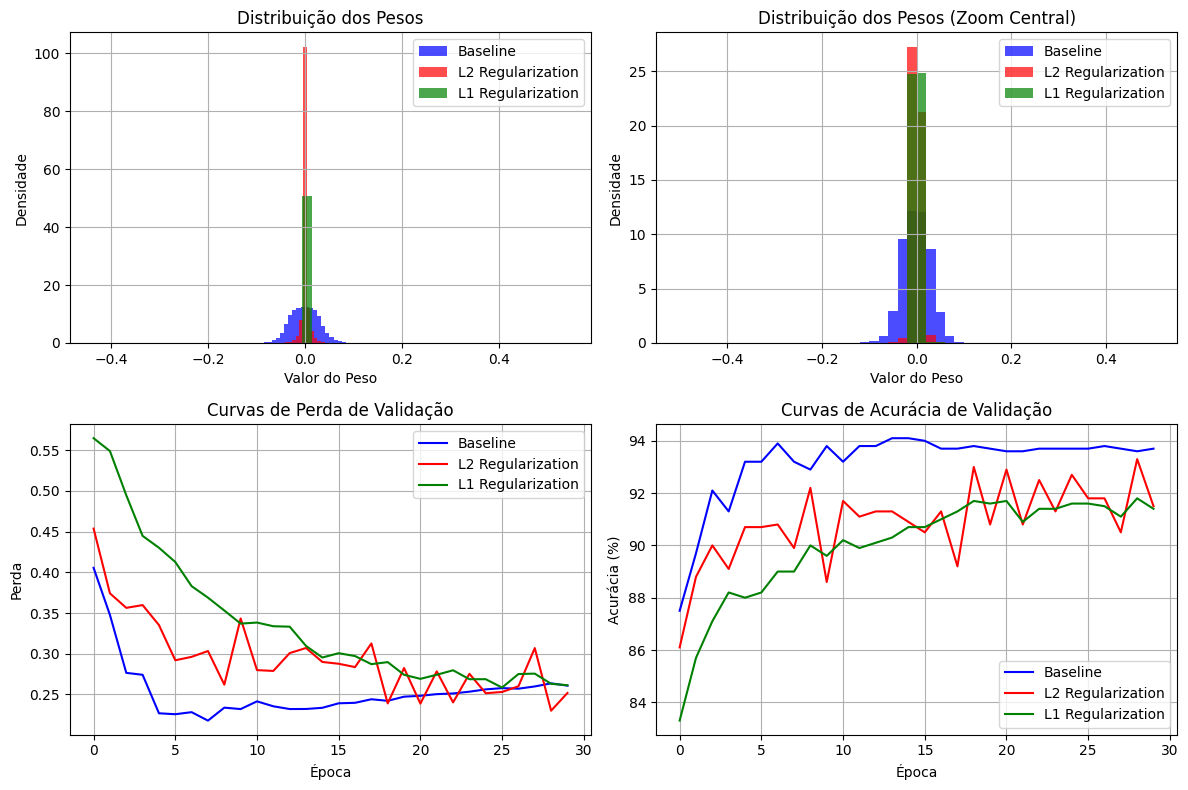

Desempenho final - Regularização L2:
Acurácia de validação: 91.50%
Perda de validação: 0.2518

Desempenho final - Regularização L1:
Acurácia de validação: 91.40%
Perda de validação: 0.2613


In [12]:
# Análise da distribuição dos pesos
def plot_weight_distributions(models, labels, colors):
    """Plota a distribuição dos pesos de diferentes modelos"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    for idx, (model, label, color) in enumerate(zip(models, labels, colors)):
        # Coletar todos os pesos do modelo
        all_weights = []
        for param in model.parameters():
            all_weights.extend(param.detach().cpu().numpy().flatten())

        all_weights = np.array(all_weights)

        # Histograma
        axes[0, 0].hist(all_weights, bins=50, alpha=0.7, label=label, color=color, density=True)

        # Estatísticas
        mean_weight = np.mean(np.abs(all_weights))
        std_weight = np.std(all_weights)
        sparsity = np.mean(np.abs(all_weights) < 1e-3) * 100  # Porcentagem de pesos "zero"

        print(f"{label}:")
        print(f"  Magnitude média: {mean_weight:.6f}")
        print(f"  Desvio padrão: {std_weight:.6f}")
        print(f"  Sparsidade: {sparsity:.2f}%")
        print()

    axes[0, 0].set_title('Distribuição dos Pesos')
    axes[0, 0].set_xlabel('Valor do Peso')
    axes[0, 0].set_ylabel('Densidade')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Zoom na região central
    for idx, (model, label, color) in enumerate(zip(models, labels, colors)):
        all_weights = []
        for param in model.parameters():
            all_weights.extend(param.detach().cpu().numpy().flatten())

        all_weights = np.array(all_weights)
        axes[0, 1].hist(all_weights, bins=50, alpha=0.7, label=label, color=color,
                       range=(-0.5, 0.5), density=True)

    axes[0, 1].set_title('Distribuição dos Pesos (Zoom Central)')
    axes[0, 1].set_xlabel('Valor do Peso')
    axes[0, 1].set_ylabel('Densidade')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Comparação das curvas de validação
    curves = [baseline_val_losses, l2_val_losses, l1_val_losses]
    for curve, label, color in zip(curves, labels, colors):
        axes[1, 0].plot(curve, label=label, color=color)

    axes[1, 0].set_title('Curvas de Perda de Validação')
    axes[1, 0].set_xlabel('Época')
    axes[1, 0].set_ylabel('Perda')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Comparação das curvas de acurácia
    curves = [baseline_val_acc, l2_val_acc, l1_val_acc]
    for curve, label, color in zip(curves, labels, colors):
        axes[1, 1].plot(curve, label=label, color=color)

    axes[1, 1].set_title('Curvas de Acurácia de Validação')
    axes[1, 1].set_xlabel('Época')
    axes[1, 1].set_ylabel('Acurácia (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

# Plotar comparações
models = [baseline_model, l2_model, l1_model]
labels = ['Baseline', 'L2 Regularization', 'L1 Regularization']
colors = ['blue', 'red', 'green']

plot_weight_distributions(models, labels, colors)

# Avaliar desempenho final
l2_val_acc_final, l2_val_loss_final = evaluate_model(l2_model, val_loader)
l1_val_acc_final, l1_val_loss_final = evaluate_model(l1_model, val_loader)

print(f"Desempenho final - Regularização L2:")
print(f"Acurácia de validação: {l2_val_acc_final:.2f}%")
print(f"Perda de validação: {l2_val_loss_final:.4f}")
print()
print(f"Desempenho final - Regularização L1:")
print(f"Acurácia de validação: {l1_val_acc_final:.2f}%")
print(f"Perda de validação: {l1_val_loss_final:.4f}")

## 4. Early Stopping

O **Early Stopping** é uma técnica de regularização que interrompe o treinamento quando a performance no conjunto de validação para de melhorar, evitando que o modelo continue aprendendo padrões específicos dos dados de treino.

### Critérios de Parada

O early stopping monitora uma métrica de validação $V(t)$ (como perda ou acurácia) ao longo das épocas $t$. O treinamento é interrompido quando:

$$V(t) > V(t-p) + \delta$$

onde:
- $p$ é a **paciência** (número de épocas sem melhoria)
- $\delta$ é a **tolerância mínima** de melhoria

Esta técnica implementa implicitamente a regularização ao limitar a capacidade do modelo de se ajustar excessivamente aos dados de treino.

In [13]:
def train_with_early_stopping(model, train_loader, val_loader, criterion, optimizer,
                             patience=5, min_delta=0.001, max_epochs=50):
    """Treinamento com early stopping"""
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0

    for epoch in range(max_epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Validação
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular métricas da época
        epoch_train_loss = train_loss / len(train_loader)
        epoch_val_loss = val_loss / len(val_loader)
        epoch_train_acc = 100 * train_correct / train_total
        epoch_val_acc = 100 * val_correct / val_total

        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)

        # Verificar early stopping
        if epoch_val_loss < best_val_loss - min_delta:
            best_val_loss = epoch_val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if (epoch + 1) % 5 == 0:
            print(f'Época [{epoch+1}/{max_epochs}] - '
                  f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% - '
                  f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}% - '
                  f'Paciência: {epochs_without_improvement}/{patience}')

        # Parar se a paciência se esgotou
        if epochs_without_improvement >= patience:
            print(f"\nEarly stopping na época {epoch + 1}")
            print(f"Melhor perda de validação: {best_val_loss:.4f}")
            break

    # Restaurar o melhor modelo
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Modelo restaurado para o melhor estado")

    return train_losses, val_losses, train_accuracies, val_accuracies, epoch + 1

Treinando modelo com Early Stopping (paciência=7)...
Época [5/50] - Train Loss: 0.1090, Train Acc: 96.65% - Val Loss: 0.2264, Val Acc: 92.90% - Paciência: 0/7
Época [10/50] - Train Loss: 0.0128, Train Acc: 99.75% - Val Loss: 0.2126, Val Acc: 93.70% - Paciência: 0/7
Época [15/50] - Train Loss: 0.0023, Train Acc: 100.00% - Val Loss: 0.2312, Val Acc: 94.10% - Paciência: 5/7

Early stopping na época 17
Melhor perda de validação: 0.2126
Modelo restaurado para o melhor estado


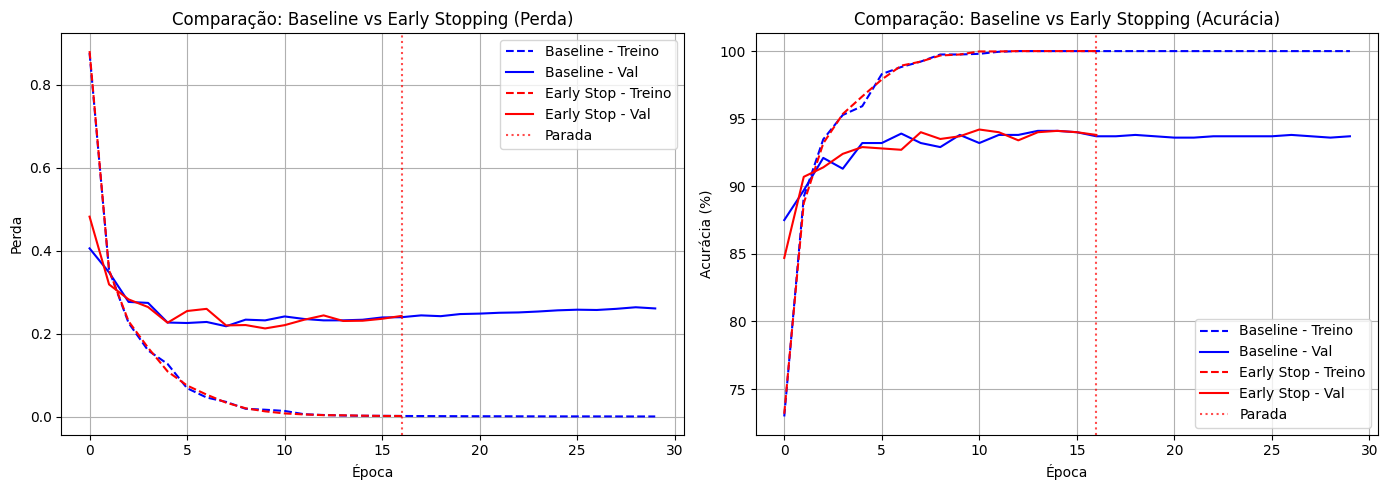


Desempenho do modelo com Early Stopping:
Acurácia de validação: 93.70%
Perda de validação: 0.2126
Épocas treinadas: 17


In [14]:
# Experimento com early stopping
early_stop_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(early_stop_model.parameters(), lr=0.001)

print("Treinando modelo com Early Stopping (paciência=7)...")
es_train_losses, es_val_losses, es_train_acc, es_val_acc, final_epoch = train_with_early_stopping(
    early_stop_model, train_loader, val_loader, criterion, optimizer,
    patience=7, min_delta=0.001, max_epochs=50
)

# Plotar resultados
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Comparação das perdas
epochs_baseline = range(len(baseline_train_losses))
epochs_es = range(len(es_train_losses))

ax1.plot(epochs_baseline, baseline_train_losses, label='Baseline - Treino', color='blue', linestyle='--')
ax1.plot(epochs_baseline, baseline_val_losses, label='Baseline - Val', color='blue', linestyle='-')
ax1.plot(epochs_es, es_train_losses, label='Early Stop - Treino', color='red', linestyle='--')
ax1.plot(epochs_es, es_val_losses, label='Early Stop - Val', color='red', linestyle='-')
ax1.axvline(x=final_epoch-1, color='red', linestyle=':', alpha=0.7, label='Parada')
ax1.set_title('Comparação: Baseline vs Early Stopping (Perda)')
ax1.set_xlabel('Época')
ax1.set_ylabel('Perda')
ax1.legend()
ax1.grid(True)

# Comparação das acurácias
ax2.plot(epochs_baseline, baseline_train_acc, label='Baseline - Treino', color='blue', linestyle='--')
ax2.plot(epochs_baseline, baseline_val_acc, label='Baseline - Val', color='blue', linestyle='-')
ax2.plot(epochs_es, es_train_acc, label='Early Stop - Treino', color='red', linestyle='--')
ax2.plot(epochs_es, es_val_acc, label='Early Stop - Val', color='red', linestyle='-')
ax2.axvline(x=final_epoch-1, color='red', linestyle=':', alpha=0.7, label='Parada')
ax2.set_title('Comparação: Baseline vs Early Stopping (Acurácia)')
ax2.set_xlabel('Época')
ax2.set_ylabel('Acurácia (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

es_val_acc_final, es_val_loss_final = evaluate_model(early_stop_model, val_loader)
print(f"\nDesempenho do modelo com Early Stopping:")
print(f"Acurácia de validação: {es_val_acc_final:.2f}%")
print(f"Perda de validação: {es_val_loss_final:.4f}")
print(f"Épocas treinadas: {final_epoch}")

## 5. Data Augmentation

O **Data Augmentation** é uma técnica que artificialmente aumenta o tamanho do dataset através de transformações que preservam a classe dos dados. Para imagens, isso inclui rotações, translações, mudanças de brilho, etc.

### Fundamentação Teórica

Data augmentation implementa uma forma de regularização ao expor o modelo a variações realísticas dos dados de treino. Matematicamente, se $\mathcal{T}$ é um conjunto de transformações válidas, então para cada amostra $(x, y)$, geramos:

$$\{(T(x), y) : T \in \mathcal{T}\}$$

Isso efetivamente aumenta o tamanho do dataset de $N$ para $N \times |\mathcal{T}|$ amostras, melhorando a capacidade de generalização.

### Invariâncias

O data augmentation ensina ao modelo **invariâncias importantes**:
- **Invariância translacional**: o objeto continua o mesmo independente da posição
- **Invariância rotacional**: pequenas rotações não alteram a classe
- **Invariância de iluminação**: mudanças de brilho não afetam a identidade

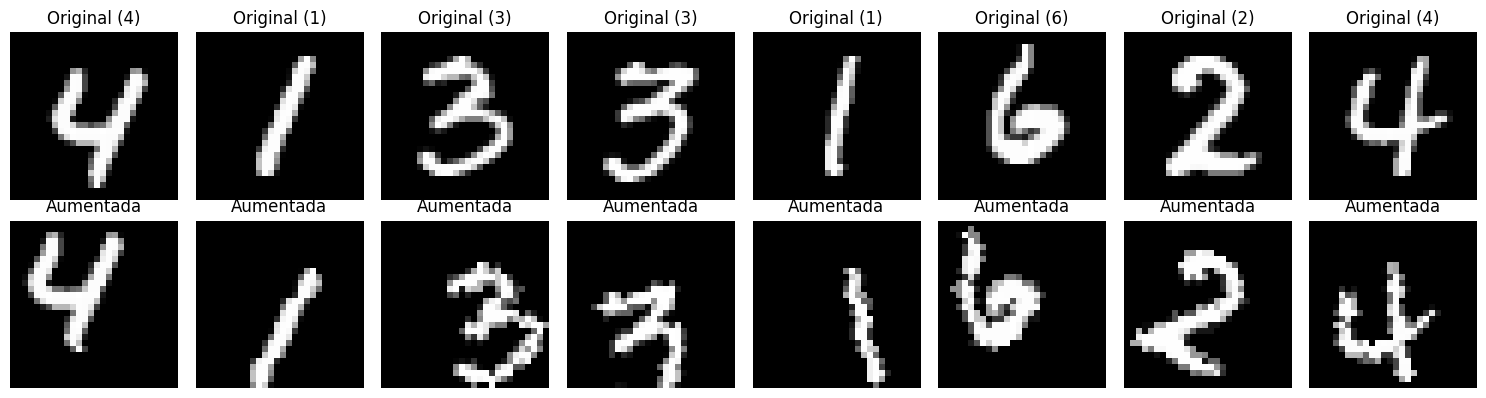

In [15]:
# Definindo transformações de data augmentation
train_transform_augmented = transforms.Compose([
    transforms.RandomRotation(10),  # Rotação aleatória de até 10 graus
    transforms.RandomAffine(degrees=30, translate=(0.2, 0.2)),  # Translação aleatória
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Dataset com data augmentation
train_dataset_augmented = torchvision.datasets.MNIST(
    root='./data', train=True, transform=train_transform_augmented, download=False
)
train_dataset_augmented = Subset(train_dataset_augmented, train_indices)
train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True)

# Visualizar algumas amostras aumentadas
def show_augmented_samples(dataset, original_dataset, num_samples=8):
    """Mostra comparação entre amostras originais e aumentadas"""
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 4))

    # Escolher índices aleatórios
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    for i, idx in enumerate(indices):
        # Amostra original
        orig_img, label = original_dataset[idx]
        orig_img = orig_img * 0.3081 + 0.1307  # Desnormalizar

        # Amostra aumentada
        aug_img, _ = dataset[idx]
        aug_img = aug_img * 0.3081 + 0.1307  # Desnormalizar

        axes[0, i].imshow(orig_img.squeeze(), cmap='gray')
        axes[0, i].set_title(f'Original ({label})')
        axes[0, i].axis('off')

        axes[1, i].imshow(aug_img.squeeze(), cmap='gray')
        axes[1, i].set_title('Aumentada')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()

show_augmented_samples(train_dataset_augmented, train_dataset)

Treinando modelo com Data Augmentation...
Época [5/30] - Train Loss: 0.9069, Train Acc: 70.55% - Val Loss: 0.4547, Val Acc: 88.10%
Época [10/30] - Train Loss: 0.5933, Train Acc: 81.35% - Val Loss: 0.2973, Val Acc: 91.70%
Época [15/30] - Train Loss: 0.5305, Train Acc: 83.80% - Val Loss: 0.2877, Val Acc: 91.80%
Época [20/30] - Train Loss: 0.4477, Train Acc: 85.50% - Val Loss: 0.2099, Val Acc: 93.20%
Época [25/30] - Train Loss: 0.3898, Train Acc: 87.47% - Val Loss: 0.1625, Val Acc: 94.90%
Época [30/30] - Train Loss: 0.3881, Train Acc: 87.42% - Val Loss: 0.1875, Val Acc: 93.80%


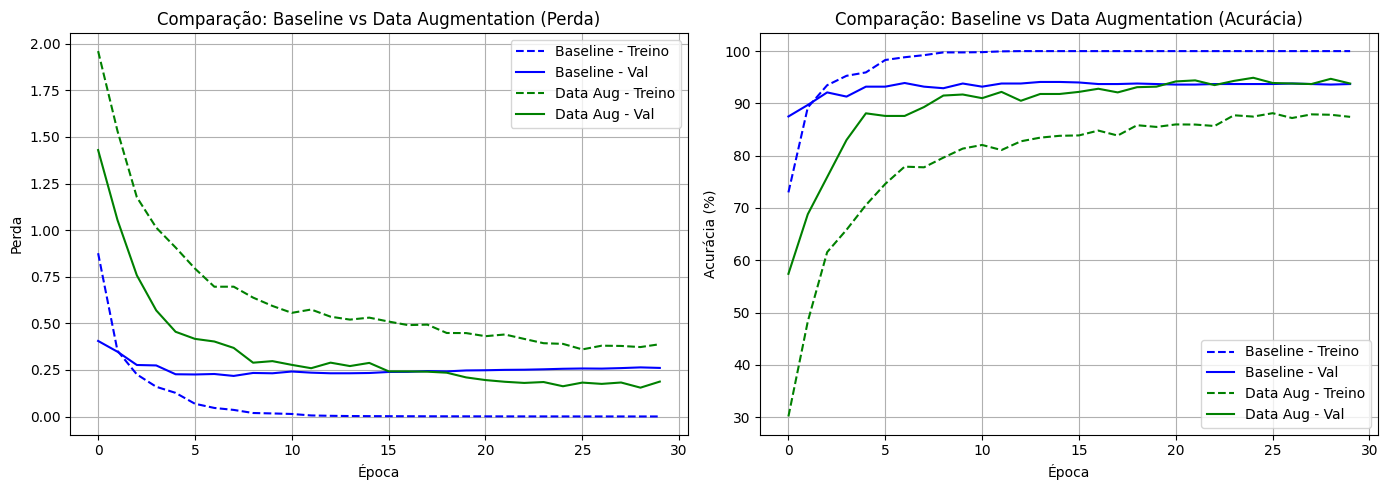


Desempenho do modelo com Data Augmentation:
Acurácia de validação: 93.80%
Perda de validação: 0.1875


In [16]:
# Experimento com data augmentation
aug_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(aug_model.parameters(), lr=0.001)

print("Treinando modelo com Data Augmentation...")
aug_train_losses, aug_val_losses, aug_train_acc, aug_val_acc = train_model(
    aug_model, train_loader_augmented, val_loader, criterion, optimizer, num_epochs=30
)

# Plotar comparação
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Comparação das perdas
ax1.plot(baseline_train_losses, label='Baseline - Treino', color='blue', linestyle='--')
ax1.plot(baseline_val_losses, label='Baseline - Val', color='blue', linestyle='-')
ax1.plot(aug_train_losses, label='Data Aug - Treino', color='green', linestyle='--')
ax1.plot(aug_val_losses, label='Data Aug - Val', color='green', linestyle='-')
ax1.set_title('Comparação: Baseline vs Data Augmentation (Perda)')
ax1.set_xlabel('Época')
ax1.set_ylabel('Perda')
ax1.legend()
ax1.grid(True)

# Comparação das acurácias
ax2.plot(baseline_train_acc, label='Baseline - Treino', color='blue', linestyle='--')
ax2.plot(baseline_val_acc, label='Baseline - Val', color='blue', linestyle='-')
ax2.plot(aug_train_acc, label='Data Aug - Treino', color='green', linestyle='--')
ax2.plot(aug_val_acc, label='Data Aug - Val', color='green', linestyle='-')
ax2.set_title('Comparação: Baseline vs Data Augmentation (Acurácia)')
ax2.set_xlabel('Época')
ax2.set_ylabel('Acurácia (%)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

aug_val_acc_final, aug_val_loss_final = evaluate_model(aug_model, val_loader)
print(f"\nDesempenho do modelo com Data Augmentation:")
print(f"Acurácia de validação: {aug_val_acc_final:.2f}%")
print(f"Perda de validação: {aug_val_loss_final:.4f}")

## Conclusões

1. **Dropout**: Eficaz e fácil de implementar. Funciona bem em redes totalmente conectadas e pode ser ajustado via taxa de dropout.

2. **Regularização L2 (Weight Decay)**: Suaviza os pesos, prevenindo valores extremos. Amplamente usado e computacionalmente eficiente.

3. **Regularização L1**: Promove sparsidade, útil para seleção automática de features. Pode ser mais difícil de otimizar.

4. **Early Stopping**: Simples e efetivo, mas requer conjunto de validação separado e monitoramento cuidadoso.

5. **Data Augmentation**: Especialmente poderoso para dados visuais, mas requer conhecimento do domínio para escolher transformações apropriadas.

## Exercícios

### Exercício 1: Experimentação com Hyperparâmetros
Teste diferentes valores de dropout rate e compare os resultados. Qual valor funciona melhor para este dataset?


### Exercício 2: Combinação de Técnicas
Crie um modelo que combine dropout com regularização L2. Compare com os modelos individuais.


### Exercício 3: Data Augmentation Customizado
Experimente diferentes transformações de data augmentation (veja a documentação do TorchVision).

### Exercício 4: Análise de Overfitting
Use um dataset ainda menor (1000 amostras de treino) e compare como cada técnica de regularização se comporta em um cenário de overfitting mais severo.

# Q1:

In [26]:
dropout_rates = [0.1, 0.3, 0.6, 0.9]
results = {}
num_epochs = 30 

for rate in dropout_rates:
    print(f"\ndropout_rate = {rate}")

    model = BaseModel(dropout_rate=rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)

    acc, loss = evaluate_model(model, val_loader)
    results[rate] = acc
    print(f"Acurácia {acc:.2f}% e Loss: {loss:.2f}%")


dropout_rate = 0.1
Época [5/30] - Train Loss: 0.1358, Train Acc: 96.00% - Val Loss: 0.2351, Val Acc: 92.80%
Época [10/30] - Train Loss: 0.0289, Train Acc: 99.12% - Val Loss: 0.2093, Val Acc: 94.20%
Época [15/30] - Train Loss: 0.0200, Train Acc: 99.50% - Val Loss: 0.2284, Val Acc: 94.10%
Época [20/30] - Train Loss: 0.0106, Train Acc: 99.75% - Val Loss: 0.1908, Val Acc: 94.70%
Época [25/30] - Train Loss: 0.0042, Train Acc: 99.92% - Val Loss: 0.2104, Val Acc: 94.70%
Época [30/30] - Train Loss: 0.0017, Train Acc: 100.00% - Val Loss: 0.2322, Val Acc: 94.40%
Acurácia 94.40% e Loss: 0.23%

dropout_rate = 0.3
Época [5/30] - Train Loss: 0.1672, Train Acc: 95.05% - Val Loss: 0.2192, Val Acc: 93.70%
Época [10/30] - Train Loss: 0.0510, Train Acc: 98.70% - Val Loss: 0.2057, Val Acc: 94.50%
Época [15/30] - Train Loss: 0.0288, Train Acc: 99.05% - Val Loss: 0.2347, Val Acc: 94.40%
Época [20/30] - Train Loss: 0.0296, Train Acc: 98.92% - Val Loss: 0.2306, Val Acc: 94.00%
Época [25/30] - Train Loss: 0.0

Com os dropouts testados acima, o melhor seria 0.6 por apresentar a melhor acuracia na ultima epoca e uma loss relativamente baixa.

# Q2:

In [27]:
num_epochs = 30
dropout_rate = 0.6
l2_lambda = 1e-4
learning_rate = 0.001

final_accuracies = {}
criterion = nn.CrossEntropyLoss()

print("---Baseline ---")
model_baseline = BaseModel(dropout_rate=0.0).to(device)
optimizer_baseline = torch.optim.Adam(model_baseline.parameters(), lr=learning_rate)
train_model(model_baseline, train_loader, val_loader, criterion, optimizer_baseline, num_epochs=num_epochs)
acc, loss = evaluate_model(model_baseline, val_loader)
final_accuracies["Baseline"] = acc
print(f"Acurácia Baseline: {acc:.2f}% e Loss: {loss:.2f}%\n")


# modelo apenas com dropout foi feito na questão passada, os parametros são os mesmos nesse
print("--- Dropout ---")
print(f"Acurácia dropout : 95.20% e Loss: 0.20%\n")

print("--- Weight Decay ---")
model_l2 = BaseModel(dropout_rate=0.0).to(device)
optimizer_l2 = torch.optim.Adam(model_l2.parameters(), lr=learning_rate, weight_decay=l2_lambda)
train_model(model_l2, train_loader, val_loader, criterion, optimizer_l2, num_epochs=num_epochs)
acc, loss = evaluate_model(model_l2, val_loader)
final_accuracies["Apenas L2"] = acc
print(f"Acurácia Apenas L2: {acc:.2f}% e Loss: {loss:.2f}%\n")


print("--- Combinado ---")
model_combined = BaseModel(dropout_rate=dropout_rate).to(device)
optimizer_combined = torch.optim.Adam(model_combined.parameters(), lr=learning_rate, weight_decay=l2_lambda)
train_model(model_combined, train_loader, val_loader, criterion, optimizer_combined, num_epochs=num_epochs)
acc, loss = evaluate_model(model_combined, val_loader)
final_accuracies["Dropout + L2"] = acc
print(f"Acurácia Combinado: {acc:.2f}% e Loss: {loss:.2f}%\n")

---Baseline ---
Época [5/30] - Train Loss: 0.1179, Train Acc: 96.53% - Val Loss: 0.2257, Val Acc: 93.20%
Época [10/30] - Train Loss: 0.0176, Train Acc: 99.80% - Val Loss: 0.2258, Val Acc: 94.20%
Época [15/30] - Train Loss: 0.0023, Train Acc: 100.00% - Val Loss: 0.2300, Val Acc: 93.80%
Época [20/30] - Train Loss: 0.0011, Train Acc: 100.00% - Val Loss: 0.2457, Val Acc: 94.10%
Época [25/30] - Train Loss: 0.0006, Train Acc: 100.00% - Val Loss: 0.2547, Val Acc: 94.00%
Época [30/30] - Train Loss: 0.0004, Train Acc: 100.00% - Val Loss: 0.2581, Val Acc: 94.20%
Acurácia Baseline: 94.20% e Loss: 0.26%

--- Dropout ---
Acurácia dropout : 95.20% e Loss: 0.20%

--- Weight Decay ---
Época [5/30] - Train Loss: 0.1051, Train Acc: 97.12% - Val Loss: 0.2254, Val Acc: 93.20%
Época [10/30] - Train Loss: 0.0205, Train Acc: 99.67% - Val Loss: 0.2378, Val Acc: 93.30%
Época [15/30] - Train Loss: 0.0024, Train Acc: 100.00% - Val Loss: 0.2385, Val Acc: 93.90%
Época [20/30] - Train Loss: 0.0013, Train Acc: 100.0

Dropout continua sendo o melhor com uma melhor  acuracia e uma loss menor

# Q3:

In [29]:
augmentation_configs = {
    
    "Rotação": transforms.Compose([
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    
    "Translação": transforms.Compose([
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]),
    
    "Perspective": transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
}

num_epochs = 30
final_results = {}
criterion = nn.CrossEntropyLoss()

for config_name, transform in augmentation_configs.items():
    print(f"--- {config_name} ---")
    
    augmented_dataset = torchvision.datasets.MNIST(
        root='./data', train=True, transform=transform, download=False
    )
    augmented_subset = Subset(augmented_dataset, train_indices)
    current_loader = DataLoader(augmented_subset, batch_size=batch_size, shuffle=True)
    

    model = BaseModel(dropout_rate=0.0).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    train_model(model, current_loader, val_loader, criterion, optimizer, num_epochs=num_epochs)
    acc, loss = evaluate_model(model, val_loader)
    final_results[config_name] = {"accuracy": acc, "loss": loss}
    print(f"Acurácia {config_name}: {acc:.2f}% - Loss: {loss:.4f}\n")


--- Rotação ---
Época [5/30] - Train Loss: 0.2167, Train Acc: 93.15% - Val Loss: 0.1887, Val Acc: 93.80%
Época [10/30] - Train Loss: 0.0895, Train Acc: 97.38% - Val Loss: 0.1691, Val Acc: 94.60%
Época [15/30] - Train Loss: 0.0747, Train Acc: 97.25% - Val Loss: 0.1577, Val Acc: 94.20%
Época [20/30] - Train Loss: 0.0268, Train Acc: 99.40% - Val Loss: 0.1318, Val Acc: 95.70%
Época [25/30] - Train Loss: 0.0184, Train Acc: 99.53% - Val Loss: 0.1593, Val Acc: 95.50%
Época [30/30] - Train Loss: 0.0196, Train Acc: 99.28% - Val Loss: 0.1612, Val Acc: 96.20%
Acurácia Rotação: 96.20% - Loss: 0.1612

--- Translação ---
Época [5/30] - Train Loss: 0.3710, Train Acc: 88.03% - Val Loss: 0.1999, Val Acc: 94.70%
Época [10/30] - Train Loss: 0.2280, Train Acc: 93.30% - Val Loss: 0.1402, Val Acc: 95.70%
Época [15/30] - Train Loss: 0.1442, Train Acc: 95.22% - Val Loss: 0.1464, Val Acc: 95.80%
Época [20/30] - Train Loss: 0.1272, Train Acc: 95.72% - Val Loss: 0.1209, Val Acc: 95.60%
Época [25/30] - Train Loss

# Q4:

In [32]:
#até 1k
train_indices = train_indices[:1000]
train_dataset = Subset(full_train_dataset, train_indices)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#baseline
baseline_model = BaseModel(dropout_rate=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_base = torch.optim.Adam(baseline_model.parameters(), lr=0.001)
base_train_loss, base_val_loss, base_train_acc, base_val_acc = train_model(
    baseline_model, train_loader, val_loader, criterion, optimizer_base, num_epochs=60
)

#weight decay
model_l2 = BaseModel(dropout_rate=0.0).to(device)
optimizer_l2 = torch.optim.Adam(model_l2.parameters(), lr=learning_rate, weight_decay=l2_lambda)
train_model(model_l2, train_loader, val_loader, criterion, optimizer_l2, num_epochs=50)
#combinado
regularized_model = BaseModel(dropout_rate=0.6).to(device)
optimizer_reg = torch.optim.Adam(
    regularized_model.parameters(), lr=0.001, weight_decay=1e-4
)
reg_train_loss, reg_val_loss, reg_train_acc, reg_val_acc = train_model(
    regularized_model, train_loader, val_loader, criterion, optimizer_reg, num_epochs=60
)

# avaliação dos modelos
baseline_acc, base_loss = evaluate_model(baseline_model, val_loader)
regularized_acc, regu_loss = evaluate_model(regularized_model, val_loader)
l2_acc, l2_loss = evaluate_model(model_l2, val_loader)

print(f"\nAcurácia final: {baseline_acc:.2f}% e loss: {base_loss:.4f}")
print(f"Acurácia final: {regularized_acc:.2f}% e loss: {regu_loss:.4f}")
print(f"Acurácia final: {l2_acc:.2f}% e loss: {l2_loss:.4f}")

Época [5/60] - Train Loss: 0.2060, Train Acc: 93.70% - Val Loss: 0.4555, Val Acc: 85.70%
Época [10/60] - Train Loss: 0.0294, Train Acc: 99.80% - Val Loss: 0.4189, Val Acc: 88.70%
Época [15/60] - Train Loss: 0.0079, Train Acc: 100.00% - Val Loss: 0.4466, Val Acc: 89.10%
Época [20/60] - Train Loss: 0.0040, Train Acc: 100.00% - Val Loss: 0.4619, Val Acc: 89.20%
Época [25/60] - Train Loss: 0.0023, Train Acc: 100.00% - Val Loss: 0.4855, Val Acc: 89.30%
Época [30/60] - Train Loss: 0.0016, Train Acc: 100.00% - Val Loss: 0.4950, Val Acc: 89.20%
Época [35/60] - Train Loss: 0.0012, Train Acc: 100.00% - Val Loss: 0.5036, Val Acc: 89.30%
Época [40/60] - Train Loss: 0.0009, Train Acc: 100.00% - Val Loss: 0.5134, Val Acc: 89.30%
Época [45/60] - Train Loss: 0.0007, Train Acc: 100.00% - Val Loss: 0.5234, Val Acc: 89.10%
Época [50/60] - Train Loss: 0.0006, Train Acc: 100.00% - Val Loss: 0.5305, Val Acc: 89.20%
Época [55/60] - Train Loss: 0.0005, Train Acc: 100.00% - Val Loss: 0.5389, Val Acc: 89.20%
Ép

Nos 3 modelos podemos ver uma redução de mais ou menos 5% na acuracia e a loss aumentando em dobro, mostrando que o modelo está errando cada vez mais na predição. E no decorrer do treinamento podemos ver exatamento o overfitting, mostrando loss muito baixas e acuracia em quase 100% no treinamento.